In [1]:
# Dependencies

import os 
import pandas as pd
import numpy as np
import re
import folium
from geopy.geocoders import Nominatim
import requests
import time
import re
import matplotlib.pyplot as plt


In [2]:
# Get names of files in directory

# Directory path where files are stored
dir_path = '/Users/sabrinaseaver/Documents/Visas/visa_files'

# List of file names
visa_files = [file for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
        
print(visa_files)

['LCA_FY_2018.csv', 'LCA_FY_2019.csv', 'LCA_FY_2021.csv', 'LCA_FY_2020.csv', 'LCA_FY_2022.csv', 'LCA_FY_2017.csv']


In [3]:
# Dataframes from csv, adding a year column to each dataframe

dict_of_dfs = {}

for file_name in visa_files:
    file_year = file_name[-8:-4]
    key_name = f'visa_{file_year}_df'
    print(key_name)
    print(file_name)
    visa_df = pd.read_csv(f'visa_files/{file_name}')
    # Adding a year column 
    visa_df['Year'] = file_year
    dict_of_dfs[key_name] = visa_df

visa_2018_df
LCA_FY_2018.csv
visa_2019_df
LCA_FY_2019.csv


/var/folders/pd/vwvrfk2568d26dsbszfbm_q80000gn/T/ipykernel_13220/1928912429.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  visa_df = pd.read_csv(f'visa_files/{file_name}')


visa_2021_df
LCA_FY_2021.csv
visa_2020_df
LCA_FY_2020.csv
visa_2022_df
LCA_FY_2022.csv
visa_2017_df
LCA_FY_2017.csv


In [4]:
# Begin cleaning the data, some dataframes had additional columns or columns with slightly different names
# Checking and changing column names so the dataframes can be merged

# Names of columns from the first dataframe
cols = set(dict_of_dfs[list(dict_of_dfs.keys())[0]].columns)
print(cols)

# Replacing column names so all the dataframes have the same column names
for df_name in list(dict_of_dfs.keys())[1:]:
    if set(dict_of_dfs[df_name].columns) != cols:
        print(f"DataFrames don't have the same columns: {df_name}")
        change = set(dict_of_dfs[df_name].columns)
        correct_column = cols.difference(change)
        correct_str = ''.join(correct_column)
        # print(f'Correct column name: {correct_column}')
        incorrect_column = ''.join(change.difference(cols))
        # print(f'Incorrect column name: {incorrect_column}')
        # Change column name
        if correct_column:
            dict_of_dfs[df_name].rename(columns={incorrect_column: correct_str}, inplace=True)
        # Drop column if not in 1st dataframe
        elif len(correct_column) == 0:   
            dict_of_dfs[df_name].drop(columns=[incorrect_column], inplace=True)
    else:
        print(f"DataFrame has the same column names {df_name}.")

{'Unit_Of_Pay', 'Job_Title', 'Year', 'Employer_Country', 'SOC_Title', 'Employer_Location', 'Employer_Name', 'Visa_Class', 'Full_Time_Position', 'Worksite', 'Prevailing_Wage', 'Case_Status'}
DataFrames don't have the same columns: visa_2019_df
DataFrames don't have the same columns: visa_2021_df
DataFrames don't have the same columns: visa_2020_df
DataFrames don't have the same columns: visa_2022_df
DataFrame has the same column names visa_2017_df.


In [5]:
# Check to make sure the dateframes have the same column names

cols = set(dict_of_dfs[list(dict_of_dfs.keys())[0]].columns)
print(cols)

for df_name in list(dict_of_dfs.keys())[1:]:
    if set(dict_of_dfs[df_name].columns) != cols:
        print(f"DataFrames don't have the same columns: {df_name}")
    else:
        print(f"Dataframes have the same column names: {df_name}")

{'Unit_Of_Pay', 'Job_Title', 'Year', 'Employer_Country', 'SOC_Title', 'Employer_Location', 'Employer_Name', 'Visa_Class', 'Full_Time_Position', 'Worksite', 'Prevailing_Wage', 'Case_Status'}
Dataframes have the same column names: visa_2019_df
Dataframes have the same column names: visa_2021_df
Dataframes have the same column names: visa_2020_df
Dataframes have the same column names: visa_2022_df
Dataframes have the same column names: visa_2017_df


In [6]:
# Combine dataframes into one dataframe.

combined_df = pd.concat(dict_of_dfs.values(), ignore_index=True)

combined_df.head()

,Visa_Class,Employer_Name,SOC_Title,Job_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Employer_Country,Case_Status,Year
0,H-1B,MICROSOFT CORPORATION,"Software Developers, Applications",SOFTWARE ENGINEER,Y,"Redmond, Washington",112549.0,Year,"Redmond, Washington",United States Of America,CERTIFIED,2018
1,H-1B,ERNST & YOUNG U.S. LLP,Accountants And Auditors,TAX SENIOR,Y,"Santa Clara, California",79976.0,Year,"Secaucus, New Jersey",United States Of America,CERTIFIED,2018
2,H-1B,LOGIXHUB LLC,Database Administrators,DATABASE ADMINISTRATOR,Y,"Irving, Texas",77792.0,Year,"Irving, Texas",United States Of America,CERTIFIED,2018
3,H-1B,"HEXAWARE TECHNOLOGIES, INC.","Software Developers, Applications",SOFTWARE ENGINEER,Y,"New Castle, Delaware",84406.0,Year,"Iselin, New Jersey",United States Of America,CERTIFIED,2018
4,H-1B,"ECLOUD LABS,INC.","Software Developers, Applications",MICROSOFT DYNAMICS CRM APPLICATION DEVELOPER,Y,"Birmingham, Alabama",87714.0,Year,"Iselin, New Jersey",United States Of America,CERTIFIED,2018


In [7]:
# Fix column data, some are uppercase, so it is consistent
combined_df['Employer_Name'] = combined_df['Employer_Name'].str.title()
combined_df['Job_Title'] = combined_df['Job_Title'].str.title()
combined_df['SOC_Title'] = combined_df['SOC_Title'].str.title()
combined_df['Case_Status'] = combined_df['Case_Status'].str.title()

In [8]:
# E-3 Australian visas only

aus_df = combined_df[combined_df['Visa_Class'] == 'E-3 Australian']
print(len(aus_df))
aus_df = aus_df.reset_index(drop=True)
aus_df

78615


,Visa_Class,Employer_Name,SOC_Title,Job_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Employer_Country,Case_Status,Year
0,E-3 Australian,Apple Inc.,"Software Developers, Applications",Maps Evaluation Software Engineer,Y,"Cupertino, California",155147.00,Year,"Cupertino, California",United States Of America,Denied,2018
1,E-3 Australian,"Marketo, Inc.",Sales Managers,"Director, Smb Sales",Y,"San Mateo, California",159060.00,Year,"San Mateo, California",United States Of America,Withdrawn,2018
2,E-3 Australian,The California Travel And Tourism Commission,Advertising And Promotions Managers,Director Of Travel Trade,Y,"Sacramento, California",90418.00,Year,"Sacramento, California",United States Of America,Denied,2018
3,E-3 Australian,Criterion Edge Inc.,Sales Managers,Senior Science Sales Manager,Y,"San Luis Obispo, California",117062.00,Year,"San Luis Obispo, California",United States Of America,Certified,2018
4,E-3 Australian,"Jean-Luc'S Wines, Llc",Web Developers,Assistant E-Commerce Director,Y,"New York, New York",24.57,Hour,"New York, New York",United States Of America,Denied,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
78610,E-3 Australian,"The Siegfried Group, Llp",Accountants And Auditors,Associate Manager,Y,"San Jose, California",79976.00,Year,"Wilmington, Delaware",NaN,Certified,2017
78611,E-3 Australian,North Carolina State University,"Biological Scientists, All Other",Research Assistant,Y,"Raleigh, North Carolina",44054.00,Year,"Raleigh, North Carolina",NaN,Certified,2017
78612,E-3 Australian,Bluestone Lane Holdings Llc,General And Operations Managers,Director Of Operations,Y,"New York, New York",71469.00,Year,"New York, New York",NaN,Certified,2017
78613,E-3 Australian,Sportsgrid Inc,Editors,"Senior Content Manager, Gaming",Y,"Los Angeles, California",0.00,NaN,"New York, New York",NaN,Denied,2017


In [9]:
# Case studies include both Certified-Withdrawn and Certified - Withdrawn, combine under Certified-Withdrawn  
aus_df.loc[aus_df['Case_Status'] == 'Certified - Withdrawn', 'Case_Status'] = 'Certified-Withdrawn'

aus_df['Case_Status'].value_counts()

Case_Status
Certified              68828
Certified-Withdrawn     4098
Denied                  3675
Withdrawn               2014
Name: count, dtype: int64

In [10]:
# Dataframe of only certified visas

aus_df_cert = aus_df[aus_df['Case_Status'] == 'Certified']
print(len(aus_df_cert))
aus_df_cert.head()

68828


,Visa_Class,Employer_Name,SOC_Title,Job_Title,Full_Time_Position,Worksite,Prevailing_Wage,Unit_Of_Pay,Employer_Location,Employer_Country,Case_Status,Year
3,E-3 Australian,Criterion Edge Inc.,Sales Managers,Senior Science Sales Manager,Y,"San Luis Obispo, California",117062.0,Year,"San Luis Obispo, California",United States Of America,Certified,2018
5,E-3 Australian,Adobe Systems Incorporated,Sales Engineers,Adobe Sign Account Executive,Y,"San Jose, California",83158.0,Year,"San Jose, California",United States Of America,Certified,2018
8,E-3 Australian,"Imperial Pacific International Cnmi, Llc",Computer And Information Systems Managers,Senior Manager - It Gaming Solutions,Y,"Saipan, Northern Mariana Islands",83860.0,Year,"Saipan, Northern Mariana Islands",United States Of America,Certified,2018
10,E-3 Australian,Macquarie America Services Inc.,Financial Managers,Senior Vice President,Y,"New York, New York",259834.0,Year,"New York, New York",United States Of America,Certified,2018
13,E-3 Australian,"Genomatica, Inc",Chief Executives,Vice President Licensing,Y,"San Diego, California",229861.0,Year,"San Diego, California",United States Of America,Certified,2018


In [11]:
# Who are the top ten employers of certified visas?

top_employers = pd.DataFrame(aus_df_cert['Employer_Name'].value_counts().head(10))
top_employers.columns = ['Count']
top_employers['Employer_Name'] = top_employers.index
top_employers = top_employers[['Employer_Name', 'Count']]
top_employers = top_employers.reset_index(drop=True)
top_employers

,Employer_Name,Count
0,Google Llc,1016
1,Amazon.Com Services Llc,683
2,Microsoft Corporation,648
3,Ernst & Young U.S. Llp,646
4,"Uber Technologies, Inc.",638
5,"Facebook, Inc.",623
6,"Tesla, Inc.",431
7,"Amazon.Com Services, Inc.",425
8,Macquarie Holdings (Usa) Inc.,375
9,Deloitte Consulting Llp,347


In [12]:
# Amazon shows up twice. Decided to group them together because they are the same company.
# Changed Amazon.Com Services, Inc to Amazon.com Services.

aus_df_cert.loc[aus_df_cert['Employer_Name'] == 'Amazon.Com Services, Inc.', 'Employer_Name'] = 'Amazon.Com Services Llc'

In [13]:
# Corrected list of top employers with both Amazon groups combined, get the top ten employers hires by year

# Group by employer name and year
grouped = aus_df_cert.groupby(['Employer_Name', 'Year']).size().reset_index(name='Total_Employees_Hired')

# Dataframe with the total employees, top ten companies
total_employees = grouped.groupby('Employer_Name')['Total_Employees_Hired'].sum().reset_index()
sorted_df = total_employees.sort_values(by='Total_Employees_Hired', ascending=False).head(10)
sorted_df

# Pivot dataframe to turn each year into a column
pivoted = grouped.pivot(index='Employer_Name', columns='Year', values='Total_Employees_Hired')


# Merge the dataframes
top_ten_companies = sorted_df.merge(pivoted, on='Employer_Name')


# Amazon and Google have no hires for 2017, showing up as NaN, replaced NaN with zero.
top_ten_companies['2017'] = top_ten_companies['2017'].fillna(0)
top_ten_companies

,Employer_Name,Total_Employees_Hired,2017,2018,2019,2020,2021,2022
0,Amazon.Com Services Llc,1108,0.0,71.0,311.0,186.0,361.0,179.0
1,Google Llc,1016,0.0,130.0,180.0,188.0,322.0,196.0
2,Microsoft Corporation,648,100.0,108.0,112.0,112.0,125.0,91.0
3,Ernst & Young U.S. Llp,646,97.0,54.0,127.0,91.0,159.0,118.0
4,"Uber Technologies, Inc.",638,88.0,87.0,136.0,115.0,144.0,68.0
5,"Facebook, Inc.",623,85.0,121.0,114.0,81.0,200.0,22.0
6,"Tesla, Inc.",431,51.0,81.0,70.0,71.0,100.0,58.0
7,Macquarie Holdings (Usa) Inc.,375,89.0,47.0,55.0,46.0,80.0,58.0
8,Deloitte Consulting Llp,347,44.0,107.0,80.0,48.0,40.0,28.0
9,Apple Inc.,321,38.0,51.0,39.0,60.0,89.0,44.0


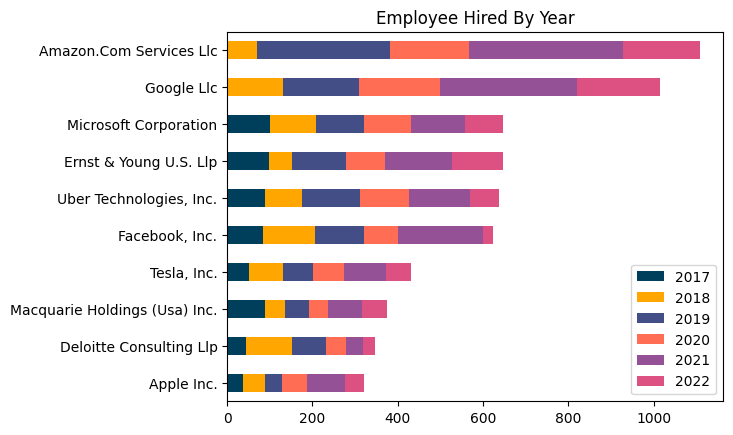

In [14]:
employees_by_years = top_ten_companies.drop(columns=['Total_Employees_Hired'])

colors = ['#003f5c', '#ffa600', '#444e86', '#ff6e54', '#955196', '#dd5182']
ax = employees_by_years.plot.barh(stacked='True', color=colors)
ax.invert_yaxis()
ax.set_yticklabels(employees_by_years['Employer_Name'])
plt.title('Employee Hired By Year')
plt.show()

In [15]:
# Where are the visas holders working

top_locations = pd.DataFrame(aus_df_cert['Worksite'].value_counts().head(10))
top_locations.columns = ['Count']
top_locations['Worksite'] = top_locations.index
top_locations = top_locations[['Worksite', 'Count']]
top_locations = top_locations.reset_index(drop=True)
top_locations

,Worksite,Count
0,"New York, New York",15285
1,"San Francisco, California",3859
2,"Los Angeles, California",2058
3,"Seattle, Washington",1684
4,"Brooklyn, New York",1421
5,"Chicago, Illinois",1158
6,"Houston, Texas",1082
7,"Austin, Texas",738
8,"Boston, Massachusetts",605
9,"Mountain View, California",597


In [16]:
# Get latitude and longitudes to build map

lat = []
lon = []

for location in top_locations['Worksite']:
    # Build url
    city, state = location.split(', ')
    city = city.replace(' ', '+')
    state = state.replace(' ', '+')
    url = f'https://nominatim.openstreetmap.org/search?q={city},+{state}&format=json'
    # Request data
    results = requests.get(url)
    results_list = results.json()[0]
    lat.append(results_list['lat'])
    lon.append(results_list['lon'])
    # Sleep to get around rate limiting
    time.sleep(2)
    
top_locations['Latitude'] = lat
top_locations['Longitude'] = lon
top_locations

,Worksite,Count,Latitude,Longitude
0,"New York, New York",15285,40.7127281,-74.0060152
1,"San Francisco, California",3859,37.7792588,-122.4193286
2,"Los Angeles, California",2058,34.0536909,-118.242766
3,"Seattle, Washington",1684,47.6038321,-122.330062
4,"Brooklyn, New York",1421,40.6526006,-73.9497211
5,"Chicago, Illinois",1158,41.8755616,-87.6244212
6,"Houston, Texas",1082,29.7589382,-95.3676974
7,"Austin, Texas",738,30.2711286,-97.7436995
8,"Boston, Massachusetts",605,42.3554334,-71.060511
9,"Mountain View, California",597,37.3893889,-122.0832101


In [17]:
center_lat, center_long = 38, -90
# Create map 
m = folium.Map(location=[center_lat, center_long], zoom_start=4)

for index, row in top_locations[['Worksite', 'Count', 'Latitude', 'Longitude']].iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Worksite']}, {row['Count']}"
    ).add_to(m)

title = 'Top Worksite Locations for Visa Workers'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title) 
m.get_root().html.add_child(folium.Element(title_html))
    
m

In [18]:
# How many visas were issued each year
visas_by_year = pd.DataFrame(aus_df_cert['Year'].value_counts())
visas_by_year.sort_index(inplace=True)
visas_by_year

,count
Year,
2017,10192
2018,10498
2019,11339
2020,9790
2021,16586
2022,10423


In [19]:
top_ten_companies

,Employer_Name,Total_Employees_Hired,2017,2018,2019,2020,2021,2022
0,Amazon.Com Services Llc,1108,0.0,71.0,311.0,186.0,361.0,179.0
1,Google Llc,1016,0.0,130.0,180.0,188.0,322.0,196.0
2,Microsoft Corporation,648,100.0,108.0,112.0,112.0,125.0,91.0
3,Ernst & Young U.S. Llp,646,97.0,54.0,127.0,91.0,159.0,118.0
4,"Uber Technologies, Inc.",638,88.0,87.0,136.0,115.0,144.0,68.0
5,"Facebook, Inc.",623,85.0,121.0,114.0,81.0,200.0,22.0
6,"Tesla, Inc.",431,51.0,81.0,70.0,71.0,100.0,58.0
7,Macquarie Holdings (Usa) Inc.,375,89.0,47.0,55.0,46.0,80.0,58.0
8,Deloitte Consulting Llp,347,44.0,107.0,80.0,48.0,40.0,28.0
9,Apple Inc.,321,38.0,51.0,39.0,60.0,89.0,44.0


In [20]:
# Dataframe of only amazon employees, SOC titles
checking = aus_df_cert.loc[aus_df_cert['Employer_Name'] == 'Apple Inc.']
checking['SOC_Title'].value_counts()


SOC_Title
Software Developers, Systems Software                 76
Software Developers, Applications                     49
Mechanical Engineers                                  20
Electrical Engineers                                  17
Art Directors                                         17
Marketing Managers                                    17
Electronics Engineers, Except Computer                14
Computer And Information Systems Managers             13
Graphic Designers                                     12
Industrial Engineers                                  10
Operations Research Analysts                           6
General And Operations Managers                        5
Multimedia Artists And Animators                       5
Computer Occupations, All Other                        4
Market Research Analysts And Marketing Specialists     4
Architectural And Engineering Managers                 4
Computer Hardware Engineers                            4
Training And Developm

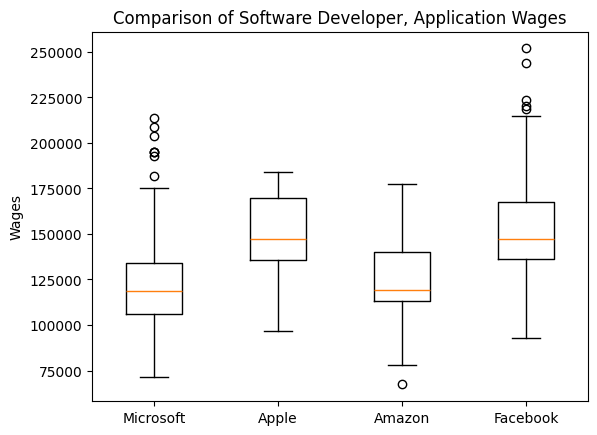

In [21]:
# Compare the prevailing wages of Software Developers, Applications among the tech companies 
# Amazon.Com Services Llc, Google Llc, Microsoft Corporation, Apple Inc.

tech_companies = ['Amazon.Com Services Llc', 'Google Llc', 'Microsoft Corporation', 'Apple Inc.']

def software_wage(company: str) -> pd.Series:
    wage_df = aus_df_cert.loc[((aus_df_cert['Employer_Name'] == company) & (aus_df_cert['SOC_Title'] == 'Software Developers, Applications'))]
    wages = wage_df['Prevailing_Wage']
    return wages

# Wage data for each company
microsoft_wages = software_wage('Microsoft Corporation')
amazon_wages = software_wage('Amazon.Com Services Llc')
apple_wages = software_wage('Apple Inc.')
google_wages = software_wage('Google Llc')
facebook_wages = software_wage('Facebook, Inc.')

# Create a figure with subplots
fig, ax = plt.subplots()

# Create boxplots for each series and add them to the figure
ax.boxplot([microsoft_wages, apple_wages, amazon_wages, facebook_wages], labels=['Microsoft', 'Apple', 'Amazon', 'Facebook'])

# Set y-axis label
ax.set_ylabel('Wages')

# Set the title of the plot
ax.set_title('Comparison of Software Developer, Application Wages')

# Show the plot
plt.show()